In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Dataset

In [2]:
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset

#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

#
# Set file paths based on added MNIST Datasets
#
input_path = './input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train_, y_train_), (X_test_, y_test_) = mnist_dataloader.load_data()

In [3]:
# output is a normal array. change it to np array.

X_train = np.array(X_train_)
y_train = np.array(y_train_)

X_test = np.array(X_test_)
y_test = np.array(y_test_)

# Turn format into (768, samples)
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T

def one_hot(y):
    n_values = np.max(y) + 1
    return np.eye(n_values)[y].T
    
y_train = one_hot(y_train)
y_test = one_hot(y_test)

In [4]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(y_train[:10])
print(y_test[:10])

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Functions

(a) Your model should use a softmax output layer with categorical cross-entropy loss.

(b) Your model should have three hidden layers. The layers should be fully connected.
The activation/transfer function of the hidden layers should have ReLU, SELU, and
hyperbolic tangent functions, respectively.

(c) Use mini-batch gradient descent (e.g. mini-batches of size 100).

(d) Implement momentum, RMSProp, or ADAM optimization algorithm.

(e) Train the network to achieve at least 94% accuracy on the test set. Tune the hyperparameters (e.g. weight initialization, learning rate) to get good performance on the
test data.

In [5]:
# https://iamtrask.github.io/2015/07/12/basic-python-network/
# https://rileylearning.medium.com/softmax-with-loss-layer-with-numpy-b21ae506729f
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

def ReLU(x):
    return np.maximum(x, 0)


def dReLU(x):
    return x > 0


# https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
# alpha and scale are pre-defined constants (alpha=1.67326324 and scale=1.05070098).
def SELU(x, alpha=1.67326324, scale=1.05070098):
    # return np.piecewise(x, [x < 0, x > 0], [lambda x: scale * alpha * np.expm1(x), lambda x: scale * x])
    x = np.clip(x, -20, 20)
    return np.where(x >= 0, scale * x, scale * alpha * np.expm1(x))


def dSELU(x, alpha=1.67326324, scale=1.05070098):
    x = np.clip(x, -20, 20)
    return np.where(x > 0, scale, scale * alpha * np.exp(x))


def tanh(x):
    return np.tanh(x)


def dtanh(x):
    return 1 - np.tanh(x)**2


# https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
def softmax(x):
    e_x = np.exp(x - np.max(x))
    # axis=0 to make it work on 2d-arrays (sum row-wise).
    return e_x / e_x.sum(axis=0)


# https://github.com/ddbourgin/numpy-ml/blob/master/numpy_ml/neural_nets/losses/losses.py#L110
# y_pred = softmax(y)
def cross_entropy(y, y_pred):
    # avoid taking log(0)
    # https://neurostars.org/t/question-about-np-finfo-float-eps/15154/3    
    eps = np.finfo(float).eps
    loss = -np.sum(y * np.log(y_pred + eps)) / y.shape[1]
    
    return loss


# https://github.com/ddbourgin/numpy-ml/blob/master/numpy_ml/preprocessing/general.py#L16-L51
# https://stackoverflow.com/questions/38157972/how-to-implement-mini-batch-gradient-descent-in-python
def create_mini_batches(X, y, batch_size=100):
    np.random.seed(637)

    m = X.shape[1]
    
    indices = np.arange(m)
    np.random.shuffle(indices)

    for idx in range(0, m, batch_size):
        excerpt = indices[idx:idx + batch_size]
        # because data samples are in columns
        yield X[:, excerpt], y[:, excerpt]


# https://github.com/protobon/deep_learning/tree/main
# https://www.mathworks.com/help/deeplearning/ug/initialize-learnable-parameters-for-custom-training-loop.html
# https://medium.com/@YasinShafiei/making-a-neural-network-fully-connected-layer-from-scratch-only-numpy-49bd7958b6f3
def init_parameters(layers):
    np.random.seed(637)
    parameters = {}

    # https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeUniform
    for l in range(1, len(layers)):
        layer_size, init_method = layers[l]
        prev_layer_size, _ = layers[l-1]

        if init_method == "he":
            limit = np.sqrt(6 / prev_layer_size)
            parameters['W' + str(l)] = np.random.uniform(-limit, limit, (layer_size, prev_layer_size))
            # parameters['W' + str(l)] = np.random.randn(layer_size, prev_layer_size) * np.sqrt(2 / prev_layer_size)
        elif init_method == "xavier":
            limit = np.sqrt(6 / (layer_size + prev_layer_size))
            parameters['W' + str(l)] = np.random.uniform(-limit, limit, (layer_size, prev_layer_size))
        elif init_method == "lecun":
            parameters['W' + str(l)] = np.random.randn(layer_size, prev_layer_size) * np.sqrt(1 / prev_layer_size)

        parameters['b' + str(l)] = np.zeros((layer_size, 1))
        
        print(f"Layer {l} - W{l}: {parameters['W' + str(l)].shape}, b{l}: {parameters['b' + str(l)].shape}, method: {init_method}")

    return parameters


# https://github.com/theroyakash/Adam/blob/master/Code/Adam.ipynb
# https://arxiv.org/abs/1412.6980
def init_adam_parameters(parameters):
    v = {}  # contain exponentially weighted average of the gradient.
    s = {}  # contain exponentially weighted average of the squared gradient.

    for l in range(1, len(parameters) // 2 + 1):
        v['dW' + str(l)] = np.zeros((parameters['W' + str(l)]).shape)
        v['db' + str(l)] = np.zeros((parameters['b' + str(l)]).shape)
        s['dW' + str(l)] = np.zeros((parameters['W' + str(l)]).shape)
        s['db' + str(l)] = np.zeros((parameters['b' + str(l)]).shape)

    return v, s


def update_adam_parameters(parameters, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    v_corrected = {}  # first moment estimates
    s_corrected = {}  # second moment estimates

    for l in range(1, len(parameters) // 2 + 1):
        dw_idx = 'dW' + str(l)
        db_idx = 'db' + str(l)
        
        # biased first moment estimate. the moving average of the gradients.
        v[dw_idx] = beta1 * v[dw_idx] + (1 - beta1) * grads[dw_idx]
        v[db_idx] = beta1 * v[db_idx] + (1 - beta1) * grads[db_idx]

        # biased corrected first moment estimate
        v_corrected[dw_idx] = v[dw_idx] / (1 - beta1 ** t)
        v_corrected[db_idx] = v[db_idx] / (1 - beta1 ** t)

        # biased second moment estimate. the moving average of squared gradients.
        s[dw_idx] = beta2 * s[dw_idx] + (1 - beta2) * (np.square(grads[dw_idx]))
        s[db_idx] = beta2 * s[db_idx] + (1 - beta2) * (np.square(grads[db_idx]))

        # biased corrected second moment estimate
        s_corrected[dw_idx] = s[dw_idx] / (1 - beta2 ** t)
        s_corrected[db_idx] = s[db_idx] / (1 - beta2 ** t)

        # update parameters with bias corrected amounts
        parameters['W' + str(l)] -= learning_rate * v_corrected[dw_idx] / (np.sqrt(s_corrected[dw_idx]) + epsilon)
        parameters['b' + str(l)] -= learning_rate * v_corrected[db_idx] / (np.sqrt(s_corrected[db_idx]) + epsilon)

    return parameters, v, s


# https://towardsdatascience.com/forward-propagation-in-neural-networks-simplified-math-and-code-version-bbcfef6f9250
def forward_propagation(X, Y, parameters):
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    W4 = parameters["W4"]
    b4 = parameters["b4"]

    # RELU -> SELU -> TANH -> SOFTMAX
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = SELU(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = tanh(Z3)
    Z4 = np.dot(W4, A3) + b4
    A4 = softmax(Z4)
    
    cache = [(A1, Z1), (A2, Z2), (A3, Z3), (A4, Z4)]
    
    return cache


def backward_propagation(X, y, caches, parameters):
    m = X.shape[1]
    grads = {}

    W4 = parameters['W4'].T
    W3 = parameters['W3'].T
    W2 = parameters['W2'].T
    
    A4, Z4 = caches[3]
    A3, Z3 = caches[2]
    A2, Z2 = caches[1]
    A1, Z1 = caches[0]

    # Backprop for softmax 
    dZ4 = A4 - y
    grads['dW4'] = np.dot(dZ4, A3.T) / m
    grads['db4'] = np.sum(dZ4) / m

    # Backprop for third layer (Tanh)
    dZ3 = np.multiply(np.dot(W4, dZ4), dtanh(Z3))
    grads['dW3'] = np.dot(dZ3, A2.T) / m 
    grads['db3'] = np.sum(dZ3) / m 

    # Backprop for second layer (SELU)
    dZ2 = np.multiply(np.dot(W3, dZ3), dSELU(Z2))
    grads['dW2'] = np.dot(dZ2, A1.T) / m
    grads['db2'] = np.sum(dZ2) / m

    # Backprop for first layer (ReLU)
    dZ1 = np.multiply(np.dot(W2, dZ2), dReLU(Z1))
    grads['dW1'] = np.dot(dZ1, X.T) / m
    grads['db1'] = np.sum(dZ1) / m

    return grads


def compute_accuracy(y, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=0)
    y_true_labels = np.argmax(y, axis=0)
    
    accuracy = np.mean(y_pred_labels == y_true_labels)
    
    return accuracy


def train(X_train, y_train, X_test, y_test, layers, num_epochs=100, batch_size=100, learning_rate=0.001):
    parameters = init_parameters(layers)
    v, s = init_adam_parameters(parameters)
    t = 1

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_loss = float('inf') 
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # running_train_loss = 0
        # running_train_accuracy = 0

        for mini_batch in create_mini_batches(X_train, y_train, batch_size):
            X_batch, y_batch = mini_batch

            caches = forward_propagation(X_batch, y_batch, parameters)

            # keep track of training loss / training acc
            # y_pred_batch = caches[3][0] # A4
            # running_train_loss += cross_entropy(y_batch, y_pred_batch)
            # running_train_accuracy += compute_accuracy(y_batch, y_pred_batch)

            grads = backward_propagation(X_batch, y_batch, caches, parameters)

            parameters, _, _ = update_adam_parameters(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8)
            t += 1

        # calculate train and testing losses.
        # avg_train_loss = running_train_loss / (t - 1)
        # avg_train_accuracy = running_train_accuracy / (t - 1)

        train_caches = forward_propagation(X_train, y_train, parameters)
        test_caches = forward_propagation(X_test, y_test, parameters)

        train_pred = train_caches[3][0]
        test_pred = test_caches[3][0]

        train_loss = cross_entropy(y_train, train_pred)
        train_acc = compute_accuracy(y_train, train_pred)
        
        test_loss = cross_entropy(y_test, test_pred)
        test_acc = compute_accuracy(y_test, test_pred)
        
        # store epoch results
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch + 1}/{num_epochs} -- train_loss: {train_loss:.6f}, train_acc: {train_acc: .6f} - test_loss: {test_loss:.6f}, test_acc: {test_acc: .6f}")

        # handle early stopping :(
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= 3: # stop epochs after patience reaches 3
            print(f"early stopping hit, best_loss: {best_test_loss}")
            break
    
    return parameters, train_losses, test_losses, train_accuracies, test_accuracies

In [6]:
# 28x28 pixels input, output 0-9.

# All acc recorded is by test_acc

# learning_rate = 0.001
# layers = [784, 128, 64, 32, 10] --> OVERFITS, ~97% ACC
# layers = [784, 64, 64, 32, 10] --> OVERFITS, ~90% ACC
# layers = [784, 64, 32, 32, 10] --> FITS OK, ~90% ACC
# layers = [784, 32, 32, 32, 10] --> FITS OK, ~90% ACC
# layers = [784, 32, 32, 64, 10] --> OVERFITS, ~92% ACC
# layers = [784, 256, 256, 128, 10] --> OVERFITS, ~98% ACC
# layers = [784, 128, 64, 64, 10] --> OVERFITS, ~96% ACC
# layers = [784, 32, 64, 32, 10] --> OVERFITS, ~95 ACC

# learning_rate = 0.005
# layers = [784, 32, 32, 32, 10] --> FITS OK, ~84% ACC
# layers = [784, 128, 64, 64, 10] --> OVERFITS, ~95% ACC

# learning_rate = 0.0005
# layers = [784, 128, 64, 64, 10]

# overfitting, 94% 0.001
# overfitting, 95% 0.0005
# layers = [
#     (784, "none"), # input
#     (64, "he"), # relu
#     (64, "lecun"), # selu
#     (64, "xavier"), # tanh
#     (10, "xavier") # softmax
# ]

# overfitting, 92% 0.001
# layers = [
#     (784, "none"), # input
#     (32, "he"), # relu
#     (32, "lecun"), # selu
#     (64, "xavier"), # tanh
#     (10, "xavier") # softmax
# ]

# overfitting, 95% 0.001
# overfitting, 95% 0.0001
# layers = [
#     (784, "none"), # input
#     (128, "he"), # relu
#     (64, "lecun"), # selu
#     (64, "xavier"), # tanh
#     (10, "xavier") # softmax
# ]

# trying after implementing early stopping.
learning_rate = 0.0001
layers = [
    (784, "none"), # input
    (64, "he"), # relu
    (64, "lecun"), # selu
    (64, "xavier"), # tanh
    (10, "xavier") # softmax
]

parameters, train_losses, test_losses, train_accuracies, test_accuracies = train(
    X_train, y_train, X_test, y_test, layers, num_epochs=100, batch_size=100, learning_rate=learning_rate
)

Layer 1 - W1: (64, 784), b1: (64, 1), method: he
Layer 2 - W2: (64, 64), b2: (64, 1), method: lecun
Layer 3 - W3: (64, 64), b3: (64, 1), method: xavier
Layer 4 - W4: (10, 64), b4: (10, 1), method: xavier
Epoch 1/100 -- train_loss: 0.840945, train_acc:  0.756067 - test_loss: 0.830374, test_acc:  0.761800
Epoch 2/100 -- train_loss: 0.553917, train_acc:  0.840650 - test_loss: 0.548210, test_acc:  0.842600
Epoch 3/100 -- train_loss: 0.450660, train_acc:  0.868367 - test_loss: 0.448746, test_acc:  0.865900
Epoch 4/100 -- train_loss: 0.401304, train_acc:  0.880933 - test_loss: 0.403886, test_acc:  0.879300
Epoch 5/100 -- train_loss: 0.358488, train_acc:  0.893117 - test_loss: 0.358851, test_acc:  0.892700
Epoch 6/100 -- train_loss: 0.324949, train_acc:  0.903900 - test_loss: 0.331827, test_acc:  0.901900
Epoch 7/100 -- train_loss: 0.303080, train_acc:  0.908983 - test_loss: 0.310881, test_acc:  0.907600
Epoch 8/100 -- train_loss: 0.285296, train_acc:  0.914517 - test_loss: 0.293712, test_acc

## (f) Plot both the training and test loss (the NLL) throughout training (at every epoch).

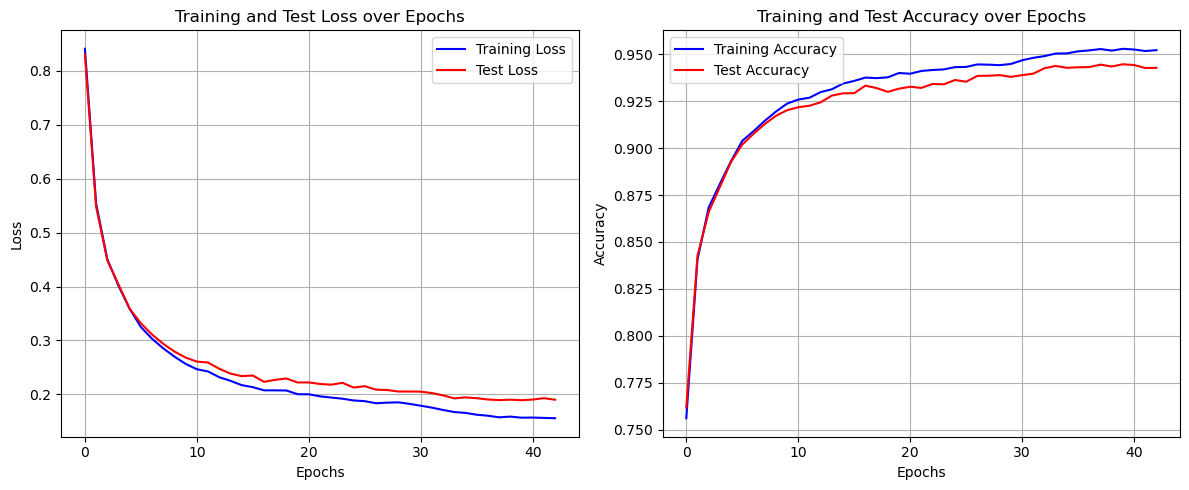

In [7]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(len(train_losses))
    
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

## display predictions

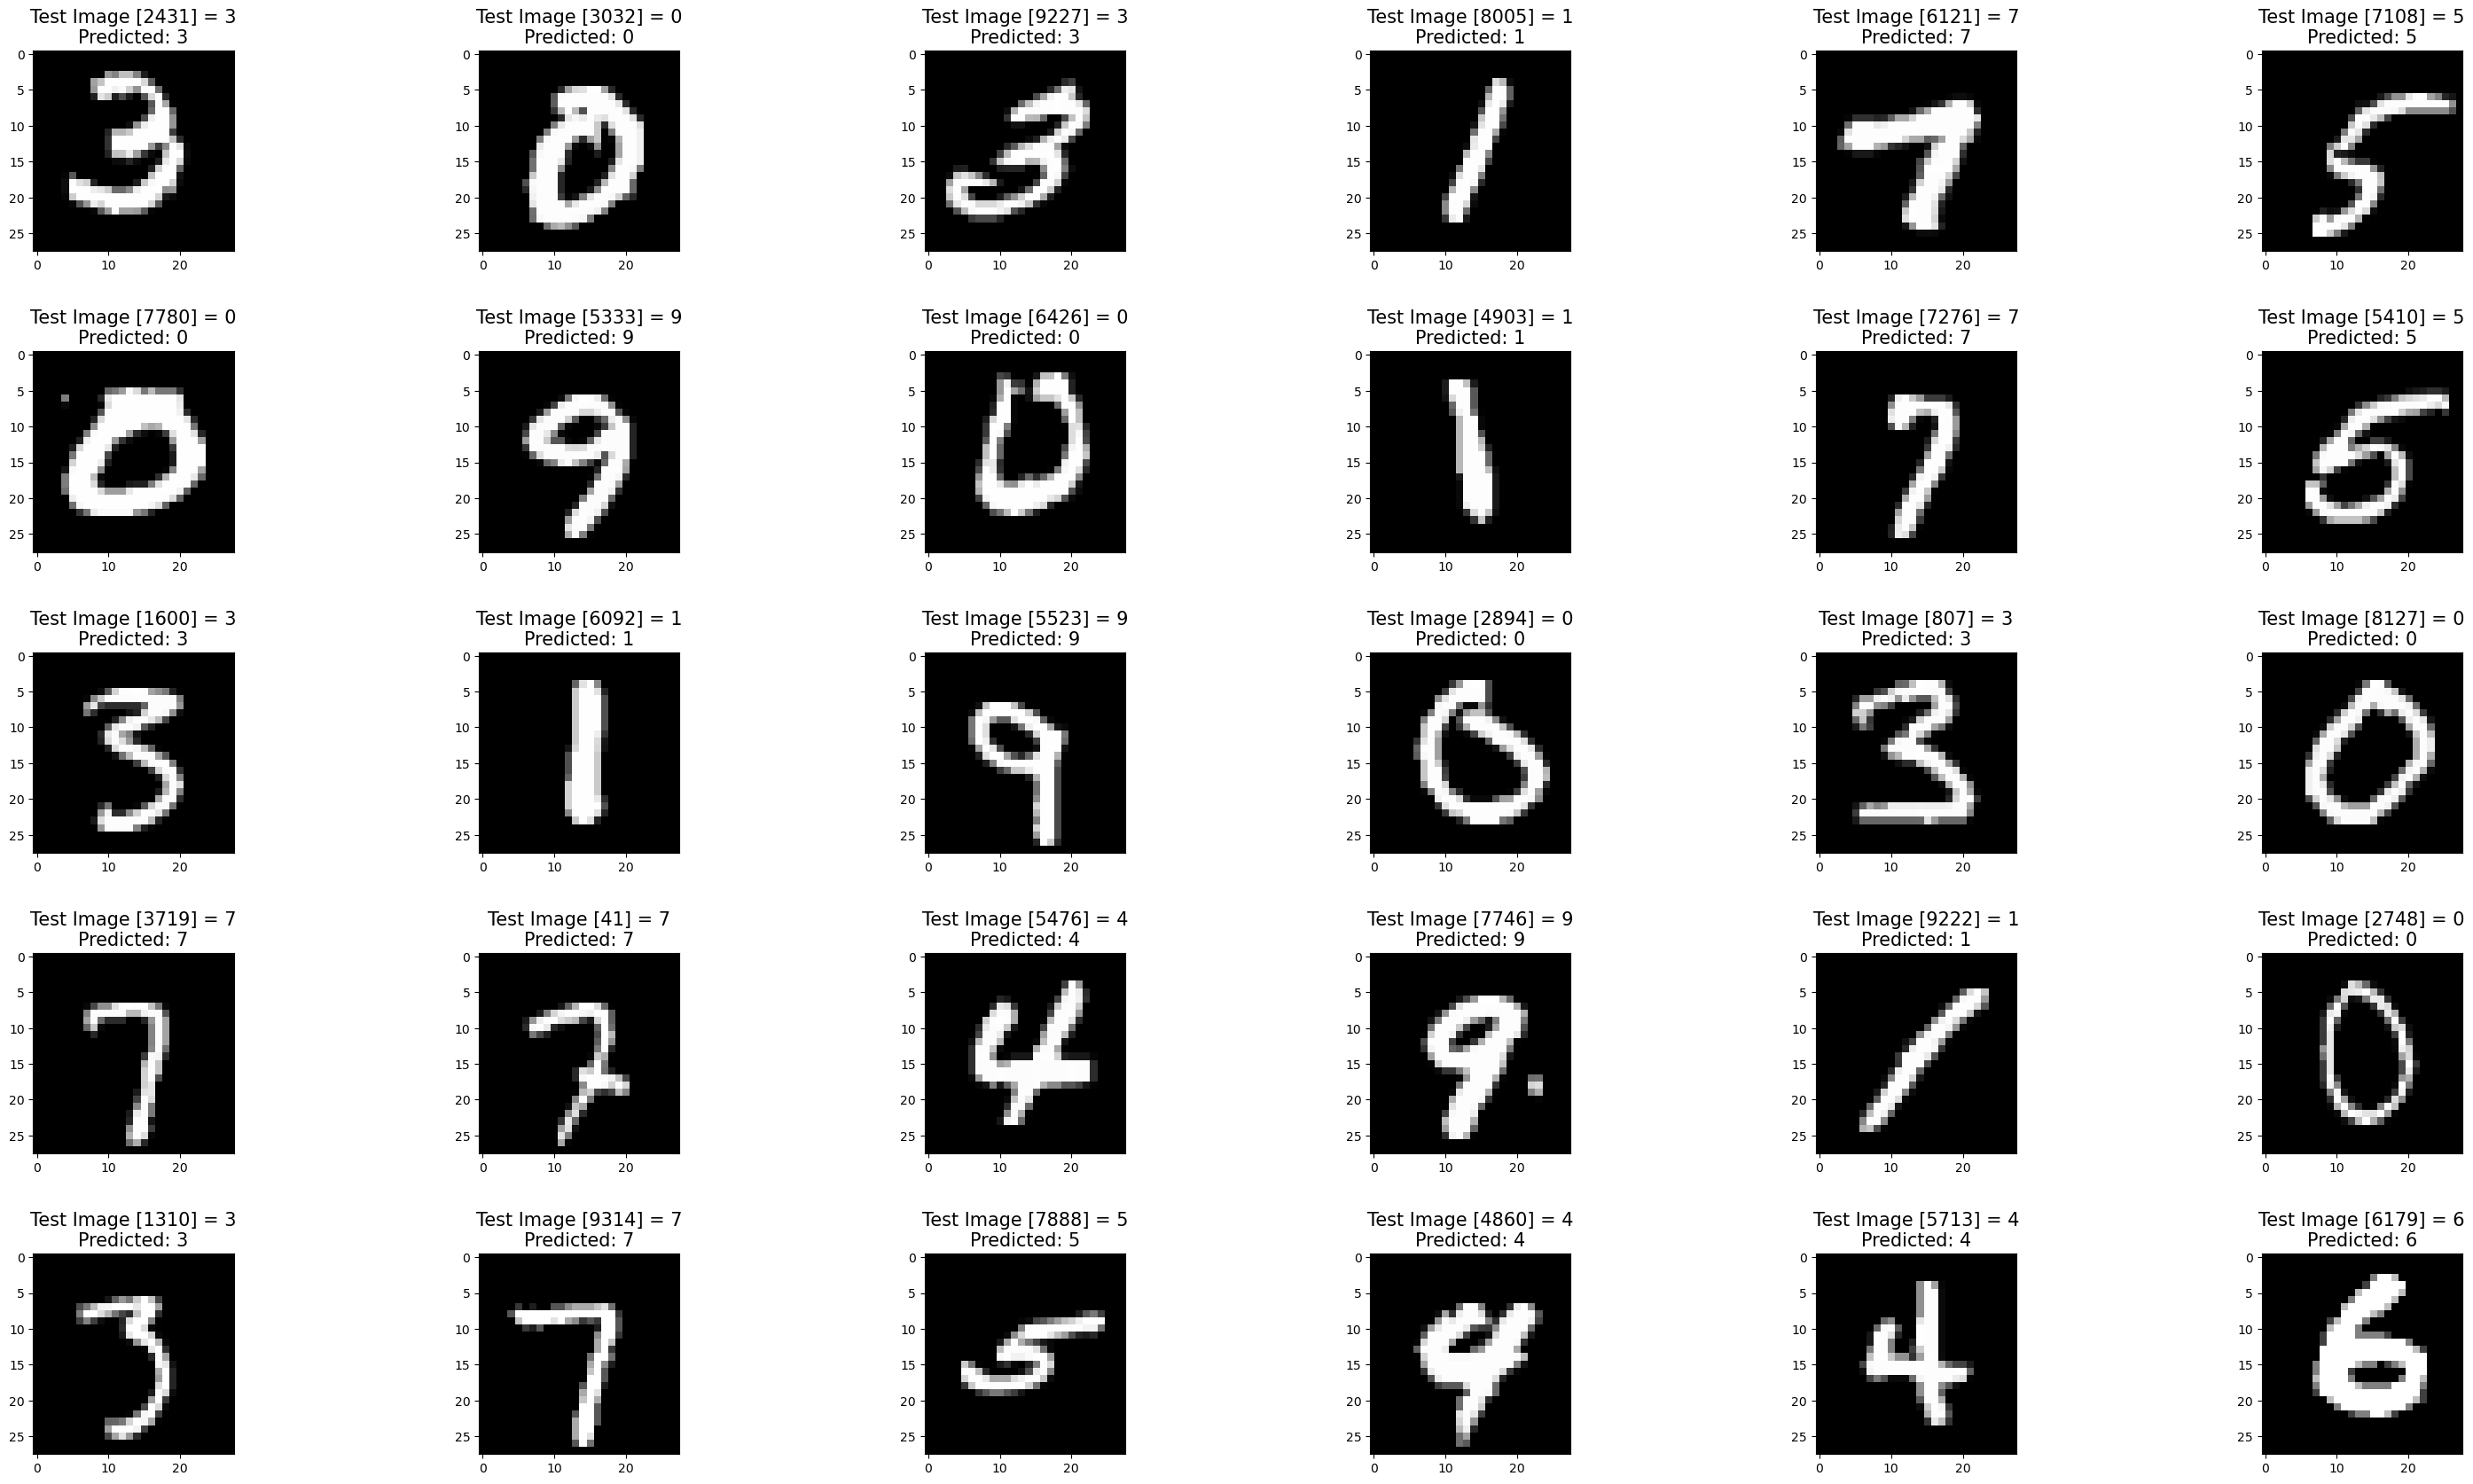

In [8]:
### ADAPTED FROM KAGGLE-MNIST-LOAD
import random

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 6
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title_text, fontsize = 15);        
        index += 1
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    plt.show()


images_2_show = []
titles_2_show = []

test_cache = forward_propagation(X_test, y_test, parameters)
predictions = np.argmax(test_cache[3][0], axis=0)

for _ in range(30):
    r = random.randint(0, X_test.shape[1] - 1)
    current_image = X_test[:, r].reshape((28, 28))  # Reshape to 28x28 and scale to 0-255 for display
    true_label = np.argmax(y_test[:, r])  # Get the actual label from one-hot encoding
    predicted_label = predictions[r]
    images_2_show.append(current_image)
    titles_2_show.append(f'Test Image [{r}] = {true_label}\nPredicted: {predicted_label}')

# Display the images with their predictions
show_images(images_2_show, titles_2_show)

# for i in range(0, 25):
#     r = random.randint(1, 10000)
#     current = X_test[:, r, None]
#     test_cache = forward_propagation(X_test, y_test, parameters)
#     prediction = np.argmax(test_cache[3][0], axis=0)
#     images_2_show.append(current.reshape((28, 28)) * 255) # because we flattened it earlier
#     titles_2_show.append('training image [' + str(r) + '] = ' + str(y_test[r]) + '\nPredicted: ' + prediction)    

# show_images(images_2_show, titles_2_show)

early stopping hit, best_loss: 0.18914909609557262</br>
Epoch 38/100 -- train_loss: 0.157395, train_acc:  0.952800 - test_loss: 0.189316, test_acc:  0.944500

## (g) Neural Network Architecture

This neural network architecture consists of five layers, with an input layer of 784 neurons representing the 28x28 pixel input images from MNIST, followed by hidden layers of sizes 64 (ReLU), 64 (SeLU), 64 (tanh), and finally the output layer (softmax) with 10 neurons corresponding to the digits 0-9. It is trained through 100 epochs, but with early stopping to prevent overfitting. To initialize the weights, uniform He initialization was used for ReLU layer, random LeCun for SeLU layer, and uniform Xavier (aka Glorot) for tanh and softmax layers. The training algorithm uses mini-batch gradient descent with a learning rate of 0.0001 with Adam optimizer. Hyperparameters were manually tuned, including layer sizes, learning rate, and batch size. This neural network achieved 95.28% accuracy on the training dataset and 94.45% accuracy on the validation dataset.